
# MSIT 3103 · Assignment 3 Hotstart Notebook  
**Prompt Engineering Lab with Local Models (Ollama + LLaMA 3.2 1B)**

> Use this notebook to run structured prompt‑engineering experiments on a **local** small model (e.g., `llama3.2:1b` via Ollama).  
> You will implement Steps 1–4 (Basic → Structured → Few‑shot → CoT), collect outputs, and analyze results.



## 0) Local Environment Check

This notebook assumes you have **[Ollama](https://ollama.com/)** installed locally and the `llama3.2:1b` model available.

- Install Ollama: follow your OS‑specific steps from the website.  
- Pull the model (in a terminal):  
```bash
ollama pull llama3.2:1b
```
- Verify command works (from terminal): `ollama run llama3.2:1b "hello"`

> If you're executing this notebook on a machine without Ollama, use these cells as **documentation** and run the actual commands on your local machine. You can paste results back here for analysis.


In [2]:

import json, os, subprocess, time, uuid, textwrap
from dataclasses import dataclass, asdict
from typing import List, Dict

RESULTS_DIR = "a3_outputs"
os.makedirs(RESULTS_DIR, exist_ok=True)

def ollama_run(model: str, prompt: str, options: Dict=None, timeout: int = 120) -> str:
    """Run a prompt through a local Ollama model via subprocess and return the text.

    Requires Ollama to be installed and available on PATH.

    """
    cmd = ["ollama", "run", model]
    if options:
        # Ollama CLI supports options via the JSON API; here we keep CLI simple.
        # For advanced options, consider using `ollama generate -m model -p prompt --options '{...}'` pattern.
        pass
    proc = subprocess.run(cmd, input=prompt.encode("utf-8"), stdout=subprocess.PIPE, stderr=subprocess.PIPE, timeout=timeout)
    if proc.returncode != 0:
        raise RuntimeError(f"Ollama error: {proc.stderr.decode('utf-8', errors='ignore')}")
    return proc.stdout.decode("utf-8", errors="ignore")

@dataclass
class Trial:
    step: str                 # basic / structured / fewshot / cot
    task_id: str              # arbitrary id of the task/question
    prompt: str
    response: str
    meta: Dict

def save_trials(trials: List[Trial], path: str):
    with open(path, "w", encoding="utf-8") as f:
        json.dump([asdict(t) for t in trials], f, ensure_ascii=False, indent=2)
    print(f"Saved {len(trials)} trials to {path}")



## 1) Context Document & Tasks

Create/Load a short **context document** (few paragraphs) and a small set of **tasks** to query the model with.  
You may replace the placeholder context and tasks below with your own domain (e.g., finance, health, policy, product requirements).

> Keep **5–10 tasks** so runs complete quickly.


In [3]:

CONTEXT = """
Apex Wealth, a financial advisory firm, is launching a new digital investment portal for its clients. The platform allows clients to monitor their portfolio performance, execute trades, and access account statements.
New features being rolled out include: an AI-powered portfolio rebalancing assistant, ESG (Environmental, Social, Governance) investment screening filters, a goal-based planning simulator (e.g., for retirement or a home purchase), and a secure direct-chat feature with their dedicated financial advisor. 
The product team tracks monthly KPIs: total Assets Under Management (AUM) on the platform, client Net Promoter Score (NPS), and average trade frequency per user.
This prompt provides a similar level of detail about the product, its features, and the key metrics for success, but sets the scenario within a wealth management context.
""".strip()

TASKS = [
    {"id": "t1", "question": "Summarize the new features of the Apex Wealth digital portal."},
    {"id": "t2", "question": "List the three KPIs being tracked and explain their significance for the business."},
    {"id": "t3", "question": "Propose two strategies or experiments to increase client Assets Under Management (AUM) on the platform."},
    {"id": "t4", "question": "Write a short FAQ answer for a client asking: 'How does the AI portfolio rebalancing assistant work?'"}
]

print(CONTEXT)
print("\nTasks:")
for t in TASKS:
    print("-", t["id"] + ":", t["question"])


Apex Wealth, a financial advisory firm, is launching a new digital investment portal for its clients. The platform allows clients to monitor their portfolio performance, execute trades, and access account statements.
New features being rolled out include: an AI-powered portfolio rebalancing assistant, ESG (Environmental, Social, Governance) investment screening filters, a goal-based planning simulator (e.g., for retirement or a home purchase), and a secure direct-chat feature with their dedicated financial advisor. 
The product team tracks monthly KPIs: total Assets Under Management (AUM) on the platform, client Net Promoter Score (NPS), and average trade frequency per user.
This prompt provides a similar level of detail about the product, its features, and the key metrics for success, but sets the scenario within a wealth management context.

Tasks:
- t1: Summarize the new features of the Apex Wealth digital portal.
- t2: List the three KPIs being tracked and explain their significanc


## 2) Step 1 — Basic Prompting

- Ask direct, simple questions grounded in the context document.
- Log correctness, completeness, and clarity for later comparison.


In [4]:

MODEL = "llama3.2:1b"

basic_trials = []
for task in TASKS:
    prompt = f"""
You are a helpful assistant.

Context:
{CONTEXT}

Question:
{task['question']}
""".strip()
    try:
        resp = ollama_run(MODEL, prompt)
    except Exception as e:
        resp = f"[ERROR running model locally] {e}"
    basic_trials.append(Trial(step="basic", task_id=task["id"], prompt=prompt, response=resp, meta={}))

save_trials(basic_trials, os.path.join(RESULTS_DIR, "step1_basic.json"))


Saved 4 trials to a3_outputs\step1_basic.json


- The Basic or zero-shot prompting approach yielded high-quality reasioning results across all tasks, demonstrating stronger performance
- Model's response were consistently clear and complete, providing insights that went beyond the explicit question
- Its output was well formatted with bulletin point or numbers for easy to interpret for humans, which makes this prompt engineering technique suitable for generating contents
- However, the drawkback is with the unstructured format, which is not machine readable and making it unsuitable for automation.


## 3) Step 2 — Structured Output Prompts

- Instruct the model to output **strict JSON** or bullet lists/tables.
- Compare accuracy & reliability with Step 1.


In [5]:

structured_trials = []
for task in TASKS:
    prompt = f"""
You are a helpful assistant. Return the answer in **strict JSON** with keys:
- "answer": string
- "supporting_facts": list of short strings derived from the context
- "confidence": number in [0,1]

Context:
{CONTEXT}

Question:
{task['question']}

If something is unknowable from the context, set "confidence": 0 and use an empty "supporting_facts".
""".strip()
    try:
        resp = ollama_run(MODEL, prompt)
    except Exception as e:
        resp = f"[ERROR running model locally] {e}"
    structured_trials.append(Trial(step="structured", task_id=task["id"], prompt=prompt, response=resp, meta={"format":"json"}))

save_trials(structured_trials, os.path.join(RESULTS_DIR, "step2_structured.json"))


Saved 4 trials to a3_outputs\step2_structured.json


- The Primary success of this technique is that it will consistently produce machine-redable JSON output making the responses predictable and can be easily for an automated system to parse and send a requests to any applications or API end point. 
- The Main trade-off is that for high structural reliablity, the response generated from structured prompting loses its readability i.e. a significant loss in content quality since the model has omitted crucial details such as failing to explain the signifiance of KPI's. 
- Responses were far more simplistic and lacked the detailed, creative and insightful ideas that were present in the basic prompting results.


## 4) Step 3 — Few‑shot Prompting

- Provide **1–3 short examples** to steer the style & content.
- Compare results with Steps 1–2.


In [6]:
FEW_SHOT_EXAMPLES = [
    {
        "q": "List two new features on the portal and what they do.",
        "a": "- AI-powered portfolio rebalancing assistant: suggests trades to align with goals\n- ESG investment screening filters: helps find socially responsible investments"
    },
    {
        "q": "What does AUM stand for and what does it measure?",
        "a": "Assets Under Management; it measures the total market value of all investments that the firm manages on the platform."
    }
]


def render_fewshot_block(examples):
    parts = ["You are a helpful assistant. Here are some QA examples:"]
    for ex in examples:
        parts.append(f"Q: {ex['q']}\nA: {ex['a']}")
    return "\n\n".join(parts)

fewshot_prefix = render_fewshot_block(FEW_SHOT_EXAMPLES)

fewshot_trials = []
for task in TASKS:
    prompt = f"""
{fewshot_prefix}

Now answer the new question using the context below.

Context:
{CONTEXT}

Question:
{task['question']}
""".strip()
    try:
        resp = ollama_run(MODEL, prompt)
    except Exception as e:
        resp = f"[ERROR running model locally] {e}"
    fewshot_trials.append(Trial(step="fewshot", task_id=task["id"], prompt=prompt, response=resp, meta={"k": len(FEW_SHOT_EXAMPLES)}))

save_trials(fewshot_trials, os.path.join(RESULTS_DIR, "step3_fewshot.json"))


Saved 4 trials to a3_outputs\step3_fewshot.json


- Few-shots prompting enforced a specific output style, like it produced a consistenet Q:A format suitable for FAQ tasks, demonstrating its strength in guiding the model's presentation where basic prompting was more conversational
- For complex tasks requiring detailed explanations or creative strategies, few-shot technique had little effect.The model largely ignored the concise examples and defaulted to the high-quality, detailed responses similar to the basic prompts.
- The only con with this method is the model can over-fit to the provided examples, leading it to apply constraints incorrectly and sacrifice the quality or completeness of its answer. 


## 5) Step 4 — Chain‑of‑Thought (CoT) Prompting

- Encourage explicit reasoning (e.g., _"Let's think step by step."_).  
- Compare reasoning quality, correctness, and verbosity with prior steps.

> **Note:** When writing your report, avoid pasting raw CoT traces if disallowed by an evaluation policy. Summarize the reasoning instead.


In [7]:
FEW_SHOT_COT_EXAMPLES = [
    {
        "q": "Which new feature helps users plan for retirement?",
        "a": """Reasoning:
1. The question asks to identify a feature related to retirement planning.
2. I need to scan the list of new features in the provided context.
3. The context mentions a "goal-based planning simulator (e.g., for retirement or a home purchase)".
4. This feature explicitly includes 'retirement' as an example use case, directly answering the question.

Final Answer: The goal-based planning simulator is the feature that helps users plan for retirement."""
    },
    {
        "q": "What does NPS stand for and why is it important?",
        "a": """Reasoning:
1. The context lists 'client Net Promoter Score (NPS)' as a key performance indicator (KPI).
2. NPS is a standard business metric used to measure customer loyalty and satisfaction.
3. Its importance for Apex Wealth is to gauge how likely clients are to recommend the service, which is a key indicator of business health and future growth.

Final Answer: NPS stands for Net Promoter Score. It is an important KPI because it measures client satisfaction and loyalty."""
    }
]

example_block = ""
for ex in FEW_SHOT_COT_EXAMPLES:
    example_block += f"Question:\n{ex['q']}\n\nAnswer:\n{ex['a']}\n\n---\n\n"

cot_fewshot_trials = []
for task in TASKS:
    prompt = f"""
You are a helpful assistant. Here are some examples of how to think step-by-step.

{example_block}Now, answer the new question following the same pattern.

Context:
{CONTEXT}

Question:
{task['question']}

Answer:
""".strip()
    try:
        resp = ollama_run(MODEL, prompt)
    except Exception as e:
        resp = f"[ERROR running model locally] {e}"
    
    trial = Trial(
        step="cot_fewshot", 
        task_id=task["id"], 
        prompt=prompt, 
        response=resp, 
        meta={"cot": True, "fewshot": True}
    )
    cot_fewshot_trials.append(trial)

save_trials(cot_fewshot_trials, os.path.join(RESULTS_DIR, "step5_cot_fewshot.json"))


Saved 4 trials to a3_outputs\step5_cot_fewshot.json



## 6) Scoring Scaffold (Manual or Programmatic)

Rate each response on:
- **Correctness** (0–5), **Completeness** (0–5), **Clarity** (0–5).  
Optionally mark factual errors.

Fill the table below manually (or write a simple heuristic scorer).


In [20]:

import json, glob, pandas as pd

def load_trials(pattern):
    rows = []
    for path in sorted(glob.glob(pattern)):
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        for item in data:
            rows.append({
                "file": os.path.basename(path),
                "step": item["step"],
                "task_id": item["task_id"],
                "prompt": item["prompt"],
                "response": item["response"],
            })
    return pd.DataFrame(rows)

df = load_trials(os.path.join(RESULTS_DIR, "step*.json"))
df.head()


file        step task_id  \
0       step1_basic.json       basic      t1   
1       step1_basic.json       basic      t2   
2       step1_basic.json       basic      t3   
3       step1_basic.json       basic      t4   
4  step2_structured.json  structured      t1   

                                              prompt  \
0  You are a helpful assistant.\n\nContext:\nApex...   
1  You are a helpful assistant.\n\nContext:\nApex...   
2  You are a helpful assistant.\n\nContext:\nApex...   
3  You are a helpful assistant.\n\nContext:\nApex...   
4  You are a helpful assistant. Return the answer...   

                                            response  
0  The Apex Wealth digital investment portal has ...  
1  In the context of Apex Wealth's new digital in...  
2  In the context of Apex Wealth's digital invest...  
3  Here's a possible FAQ response:\n\n"Dear [Clie...  
4  ```json\n{\n  "answer": "The Apex Wealth digit...

In [21]:

# Add scoring columns and export a CSV for manual rating
df_scores = df.copy()
for col in ["correctness_0_5", "completeness_0_5", "clarity_0_5", "notes"]:
    if col not in df_scores.columns:
        df_scores[col] = ""

out_csv = os.path.join(RESULTS_DIR, "ratings_template.csv")
df_scores.to_csv(out_csv, index=False)
out_csv


'a3_outputs\\ratings_template.csv'


## 7) Aggregate & Compare

After you fill in `ratings_template.csv`, re‑import and compute per‑step averages.


In [22]:

import pandas as pd, numpy as np

ratings_path = os.path.join(RESULTS_DIR, "ratings_template.csv")
ratings = pd.read_csv(ratings_path)

def to_num(x):
    try:
        return float(x)
    except:
        return np.nan

ratings["correctness_0_5"] = ratings["correctness_0_5"].apply(to_num)
ratings["completeness_0_5"] = ratings["completeness_0_5"].apply(to_num)
ratings["clarity_0_5"] = ratings["clarity_0_5"].apply(to_num)

summary = ratings.groupby("step")[["correctness_0_5","completeness_0_5","clarity_0_5"]].mean().round(2)
summary


correctness_0_5  completeness_0_5  clarity_0_5
step                                                       
basic                   4.75              5.00          5.0
cot_fewshot             4.00              4.25          4.0
fewshot                 5.00              4.75          5.0
structured              3.75              2.75          3.0

In [43]:
summary.index.name = "Prompt Technique"

In [44]:
summary.rename(columns = {"correctness_0_5" : "Avg. Correctness", "completeness_0_5" : "Avg. Completeness", "clarity_0_5" : "Avg. Clarity" }, index= {"basic" : "Basic (Zero-shot)", "cot_fewshot": "CoT Few-shot", "fewshot" : "Few-shot", "structured" : "Structured"}, inplace= True)

In [45]:
summary

Avg. Correctness  Avg. Completeness  Avg. Clarity
Prompt Technique                                                    
Basic (Zero-shot)              4.75               5.00           5.0
CoT Few-shot                   4.00               4.25           4.0
Few-shot                       5.00               4.75           5.0
Structured                     3.75               2.75           3.0


## 8) Visualization

Plot average scores by step (Basic vs Structured vs Few‑shot vs CoT).


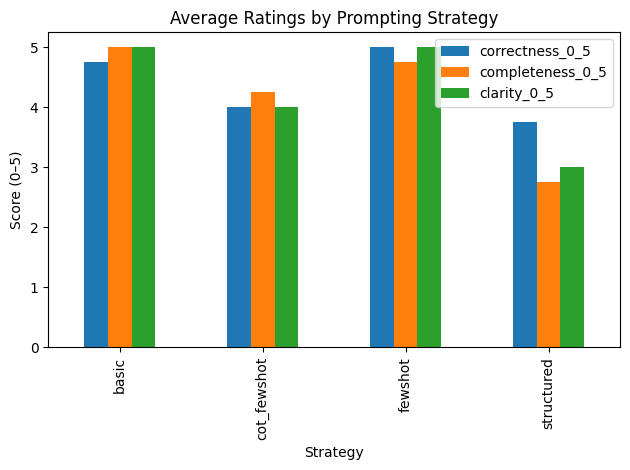

In [23]:

import matplotlib.pyplot as plt

summary.plot(kind="bar")
plt.title("Average Ratings by Prompting Strategy")
plt.ylabel("Score (0–5)")
plt.xlabel("Strategy")
plt.tight_layout()
plt.show()
